In [80]:
import torch
from torch import nn

import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor

import matplotlib.pyplot as plt

print(torch.__version__, torchvision.__version__)

2.7.1 0.22.1


In [81]:
train_data = datasets.FashionMNIST(
    root='data',
    train=True,
    transform=ToTensor(),
    target_transform=None,
    download=True
)

test_data = datasets.FashionMNIST(
    root='data',
    train=False,
    transform=ToTensor(),
    target_transform=None,
    download=True
)

In [82]:
image, label = train_data[0]
image.shape,label

(torch.Size([1, 28, 28]), 9)

In [83]:
len(train_data.data), len(train_data.targets), len(test_data.data), len(test_data.targets)

(60000, 60000, 10000, 10000)

In [84]:
class_names = train_data.classes
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

Text(0.5, 1.0, 'Ankle boot')

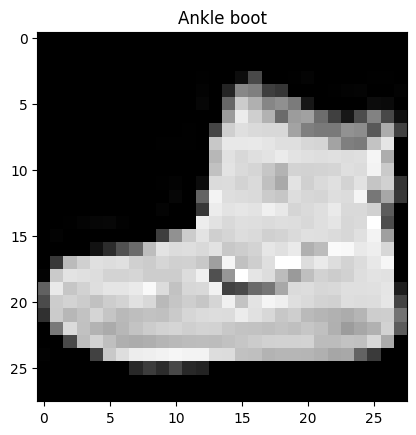

In [85]:
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap="grey")
plt.title(label=class_names[label])

In [86]:
from torch.utils.data import DataLoader
import torchmetrics

In [87]:
cuda_available = torch.cuda.is_available()
print(f"CUDA Available: {cuda_available}")
mps_available = torch.mps.is_available()
print(f"MPS Available: {mps_available}")
device = torch.device("cuda" if torch.cuda.is_available() else "mps" if torch.backends.mps.is_available() else "cpu")
print(f"Using device: {device}")

CUDA Available: False
MPS Available: True
Using device: mps


In [88]:
BATCH_SIZE = 32

train_dataloader = DataLoader(train_data,
                              batch_size=BATCH_SIZE,
                              shuffle=True)

test_dataloader = DataLoader(test_data,
                             batch_size=BATCH_SIZE,
                             shuffle=False)

print(train_dataloader)
print(test_dataloader)
print(len(train_dataloader), len(test_dataloader))

1875 313


In [89]:
train_features_batch, train_labels_batch = next(iter(train_dataloader))
train_features_batch.shape, train_labels_batch.shape

(torch.Size([32, 1, 28, 28]), torch.Size([32]))

In [90]:
class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [91]:
torch.manual_seed(seed=7)

model_0 = FashionMNISTModelV0(input_shape=784, hidden_units=10, output_shape=len(class_names))
model_0.to("cpu")

FashionMNISTModelV0(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): Linear(in_features=10, out_features=10, bias=True)
  )
)

In [92]:
def accuracy_fn(y_true, y_pred):
    """Calculates accuracy between truth labels and predictions.

    Args:
        y_true (torch.Tensor): Truth labels for predictions.
        y_pred (torch.Tensor): Predictions to be compared to predictions.

    Returns:
        [torch.float]: Accuracy value between y_true and y_pred, e.g. 78.45
    """
    correct = torch.eq(y_true, y_pred).sum().item()
    acc = (correct / len(y_pred)) * 100
    return acc


In [93]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_0.parameters(), lr=0.1)

In [94]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    """Prints difference between start and end time.

    Args:
        start (float): Start time of computation (preferred in timeit format). 
        end (float): End time of computation.
        device ([type], optional): Device that compute is running on. Defaults to None.

    Returns:
        float: time between start and end in seconds (higher is longer).
    """
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time

In [95]:
from tqdm.auto import tqdm


In [96]:
torch.manual_seed(seed=7)
train_time_start_on_cpu = timer()

epochs = 5

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n==========")

    train_loss = 0
    for batch, (X, y) in enumerate(train_dataloader):
        model_0.train()
        y_pred = model_0(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        if batch%400 == 0:
            print(f"Looked at {batch * len(X)}/{len(train_dataloader.dataset)} samples")
    train_loss /= len(train_dataloader) # AVG loss per batch per epoch

    test_loss, test_acc = 0, 0
    model_0.eval()

    with torch.inference_mode():
        for X, y in test_dataloader:
            test_pred = model_0(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y, test_pred.argmax(dim=1))
        test_loss /= len(test_dataloader)
        test_acc /= len(test_dataloader)
        print(f"\nTrain loss: {train_loss:.5f} | Test loss: {test_loss:.5f}, Test acc: {test_acc:.2f}%\n")


train_time_end_on_cpu = timer()
total_train_time_model_0 = print_train_time(start=train_time_start_on_cpu, 
                                           end=train_time_end_on_cpu,
                                           device=str(next(model_0.parameters()).device))


  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 20%|██        | 1/5 [00:01<00:06,  1.52s/it]


Train loss: 0.59234 | Test loss: 0.49750, Test acc: 82.29%

Epoch: 1
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 40%|████      | 2/5 [00:03<00:04,  1.50s/it]


Train loss: 0.48084 | Test loss: 0.51874, Test acc: 81.82%

Epoch: 2
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 60%|██████    | 3/5 [00:04<00:02,  1.49s/it]


Train loss: 0.45674 | Test loss: 0.46474, Test acc: 83.64%

Epoch: 3
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


 80%|████████  | 4/5 [00:06<00:01,  1.53s/it]


Train loss: 0.44260 | Test loss: 0.48133, Test acc: 82.97%

Epoch: 4
Looked at 0/60000 samples
Looked at 12800/60000 samples
Looked at 25600/60000 samples
Looked at 38400/60000 samples
Looked at 51200/60000 samples


100%|██████████| 5/5 [00:07<00:00,  1.51s/it]


Train loss: 0.43695 | Test loss: 0.45457, Test acc: 84.12%

Train time on cpu: 7.575 seconds


In [97]:
torch.manual_seed(seed=7)

def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            y_pred = model(X)
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y, y_pred.argmax(dim=1))
        loss /= len(data_loader)
        acc /= len(data_loader)

    return {"model_name": model.__class__.__name__,
        "model_loss": loss.item(),
        "model_acc": acc} 

In [99]:
model_0_results = eval_model(model=model_0, data_loader=test_dataloader,
    loss_fn=loss_fn, accuracy_fn=accuracy_fn, device="cpu"
)
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.45456936955451965,
 'model_acc': 84.11541533546325}

In [100]:
device

device(type='mps')

In [101]:
class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )
    
    def forward(self, x):
        return self.layer_stack(x)

In [102]:
torch.manual_seed(seed=7)

model_1 = FashionMNISTModelV1(input_shape=784, hidden_units=10, output_shape=len(class_names))
model_1.to(device)
print(model_1)
next(model_1.parameters()).device

FashionMNISTModelV1(
  (layer_stack): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=784, out_features=10, bias=True)
    (2): ReLU()
    (3): Linear(in_features=10, out_features=10, bias=True)
    (4): ReLU()
  )
)


device(type='mps', index=0)

In [103]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_1.parameters(), lr=0.1)

In [104]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))

        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

In [105]:
def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    test_loss, test_acc = 0, 0
    model.to(device)
    model.eval()
    with torch.inference_mode(): 
        for X, y in data_loader:
            X, y = X.to(device), y.to(device)
            test_pred = model(X)
            test_loss += loss_fn(test_pred, y)
            test_acc += accuracy_fn(y_true=y,
                y_pred=test_pred.argmax(dim=1)
            )
        
        test_loss /= len(data_loader)
        test_acc /= len(data_loader)
        print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [106]:
torch.manual_seed(7)

epochs = 5
train_time_start_on_mps = timer()

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n==========")

    train_step(model_1,
               train_dataloader,
               loss_fn,
               optimizer,
               accuracy_fn,
               device)
    
    test_step(test_dataloader,
              model_1,
              loss_fn,
              accuracy_fn,
              device)

train_time_end_on_mps = timer()
total_train_time_model_1 = print_train_time(start=train_time_start_on_mps, 
                                           end=train_time_end_on_mps,
                                           device=str(next(model_1.parameters()).device))

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
Train loss: 0.85193 | Train accuracy: 72.25%


 20%|██        | 1/5 [00:04<00:17,  4.43s/it]

Test loss: 0.68998 | Test accuracy: 77.10%

Epoch: 1
Train loss: 0.66766 | Train accuracy: 77.27%


 40%|████      | 2/5 [00:08<00:13,  4.43s/it]

Test loss: 0.68066 | Test accuracy: 76.99%

Epoch: 2
Train loss: 0.63575 | Train accuracy: 78.14%


 60%|██████    | 3/5 [00:13<00:08,  4.46s/it]

Test loss: 0.66311 | Test accuracy: 77.17%

Epoch: 3
Train loss: 0.61731 | Train accuracy: 78.64%


 80%|████████  | 4/5 [00:17<00:04,  4.42s/it]

Test loss: 0.65532 | Test accuracy: 77.43%

Epoch: 4
Train loss: 0.60809 | Train accuracy: 79.08%


100%|██████████| 5/5 [00:22<00:00,  4.42s/it]

Test loss: 0.63047 | Test accuracy: 78.43%

Train time on mps:0: 22.084 seconds


In [107]:
model_1_results = eval_model(model=model_1, 
    data_loader=test_dataloader,
    loss_fn=loss_fn, 
    accuracy_fn=accuracy_fn, device=device)
model_1_results

{'model_name': 'FashionMNISTModelV1',
 'model_loss': 0.6304709315299988,
 'model_acc': 78.43450479233226}

In [108]:
model_0_results

{'model_name': 'FashionMNISTModelV0',
 'model_loss': 0.45456936955451965,
 'model_acc': 84.11541533546325}

In [109]:
# CNN

class FashionMNISTModelV2(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units,
                      out_channels=hidden_units,
                      kernel_size=3,
                      stride=1,
                      padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2,
                         stride=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7,
                      out_features=output_shape)
        )

    def forward(self, x):
        x = self.block_1(x)
        x = self.block_2(x)
        x = self.classifier(x)
        return x

In [110]:
model_2 = FashionMNISTModelV2(input_shape=1,
                              hidden_units=10,
                              output_shape=len(class_names)).to(device)

model_2

FashionMNISTModelV2(
  (block_1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block_2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [112]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model_2.parameters(), 
                             lr=0.1)

In [113]:
torch.manual_seed(7)

train_time_start_model_2 = timer()

for epoch in tqdm(range(epochs)):
    print(f"Epoch: {epoch}\n==========")

    train_step(model_2,
               train_dataloader,
               loss_fn,
               optimizer,
               accuracy_fn,
               device)
    
    test_step(test_dataloader,
              model_2,
              loss_fn,
              accuracy_fn,
              device)

train_time_end_on_model_2 = timer()
total_train_time_model_2 = print_train_time(start=train_time_start_model_2, 
                                           end=train_time_end_on_model_2,
                                           device=str(next(model_2.parameters()).device))
    

  0%|          | 0/5 [00:00<?, ?it/s]

Epoch: 0
Train loss: 0.57815 | Train accuracy: 79.07%


 20%|██        | 1/5 [00:06<00:27,  6.90s/it]

Test loss: 0.38554 | Test accuracy: 85.97%

Epoch: 1
Train loss: 0.34662 | Train accuracy: 87.60%


 40%|████      | 2/5 [00:13<00:20,  6.84s/it]

Test loss: 0.35843 | Test accuracy: 86.48%

Epoch: 2
Train loss: 0.30860 | Train accuracy: 88.87%


 60%|██████    | 3/5 [00:20<00:13,  6.84s/it]

Test loss: 0.32106 | Test accuracy: 88.58%

Epoch: 3
Train loss: 0.28767 | Train accuracy: 89.69%


 80%|████████  | 4/5 [00:27<00:06,  6.87s/it]

Test loss: 0.31426 | Test accuracy: 88.45%

Epoch: 4
Train loss: 0.27679 | Train accuracy: 90.01%


100%|██████████| 5/5 [00:34<00:00,  6.87s/it]

Test loss: 0.30439 | Test accuracy: 89.17%

Train time on mps:0: 34.330 seconds


In [114]:
model_2_results = eval_model(
    model=model_2,
    data_loader=test_dataloader,
    loss_fn=loss_fn,
    accuracy_fn=accuracy_fn, device=device
)
model_2_results

{'model_name': 'FashionMNISTModelV2',
 'model_loss': 0.3043856620788574,
 'model_acc': 89.1673322683706}

In [115]:
def make_predictions(model: torch.nn.Module,
                     data: list,
                     device: torch.device):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob.cpu())
    return torch.stack(pred_probs)

In [117]:
import random

In [118]:
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

print(f"Test sample image shape: {test_samples[0].shape}\nTest sample label: {test_labels[0]} ({class_names[test_labels[0]]})")

Test sample image shape: torch.Size([1, 28, 28])
Test sample label: 9 (Ankle boot)


In [123]:
pred_probs= make_predictions(model=model_2, 
                             data=test_samples, device=device)

pred_probs[:2]

tensor([[1.5942e-10, 3.1140e-14, 1.9666e-12, 2.7685e-10, 3.2460e-11, 3.3137e-07,
         4.5822e-10, 1.7948e-06, 1.7286e-07, 1.0000e+00],
        [3.4142e-02, 3.0573e-06, 2.0226e-03, 7.2932e-07, 3.6601e-04, 1.3999e-05,
         1.8168e-02, 4.2912e-05, 9.4440e-01, 8.3713e-04]])

In [124]:
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([9, 8, 6, 3, 1, 0, 9, 8, 8])

In [125]:
test_labels, pred_classes

([9, 8, 6, 3, 1, 0, 9, 8, 8], tensor([9, 8, 6, 3, 1, 0, 9, 8, 8]))

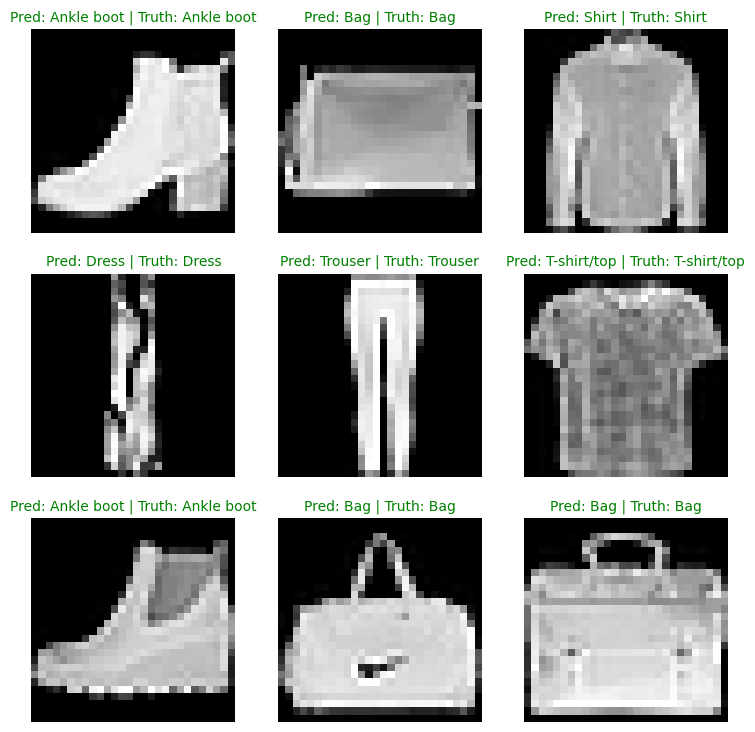

In [128]:
plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3
for i, sample in enumerate(test_samples):
  plt.subplot(nrows, ncols, i+1)

  plt.imshow(sample.squeeze(), cmap="gray")

  pred_label = class_names[pred_classes[i]]

  truth_label = class_names[test_labels[i]] 

  title_text = f"Pred: {pred_label} | Truth: {truth_label}"
  
  if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g")
  else:
      plt.title(title_text, fontsize=10, c="r")
  plt.axis(False)